### Final Project - Notebook 1
#### Article clean-up and filtering
#### Topic detection
#### Sentiment analysis (explicitly customized)### Final otebook 1 - 
#### Article clean-up and filtering
#### Topic detection
#### Sentiment analysis (explicitly customized)

In [2]:
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import pandas as pd
import re
import sys

import time
import math
import re
from textblob import TextBlob
import pandas as pd


from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import string

import os
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim

In [3]:
from __future__ import division

### Data cleanup and topic modelling

In [ ]:
#Data Cleanup
data=pd.read_pickle('news_chicago_il.pkl')
data=data[~(data['text'].str.contains('episode'))]

data['text'] = data['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

doc_complete=[]
for x in data['text']:
    if len(x)>200:
        doc_complete.append(x)

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete] 

#LDA Topic Modelling
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

Lda = gensim.models.ldamodel.LdaModel

%time ldamodel = Lda(doc_term_matrix, num_topics=15, id2word = dictionary, passes=50) #5 topics
print(*ldamodel.print_topics(num_topics=15, num_words=5), sep='\n')

#Filtering out the articles where topic_perc_contribution is less than 0.4
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


new_data=df_dominant_topic[df_dominant_topic['Topic_Perc_Contrib']>0.4]
with open('new_data.pickle', 'wb') as f:
    pickle.dump(new_data, f, pickle.HIGHEST_PROTOCOL)


In [34]:
new_data.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_text
0,0,4.0,0.6390,"police, chicago, said, shot, johnson, officer,...","[news, october, 31st, 2019, ric, hansoncedar, ...","[News, October, 31st, 2019, Ric, HansonCEDAR, ..."
1,1,0.0,0.9612,"teacher, school, union, chicago, strike, said,...","[chicago, teacher, union, voted, approve, tent...","[Chicagos, teacher, union, voted, approve, ten..."
2,2,6.0,0.4325,"state, illinois, said, city, chicago, trump, p...","[news, knowthis, trump, v, chicago, relentless...","[News, KnowThis, Trump, v, Chicago, Relentless..."
3,3,11.0,0.4036,"market, exchange, user, service, data, company...","[may, noticed, market, taking, beating, dow, p...","[You, may, noticed, market, taking, beating, T..."
4,4,0.0,0.9316,"teacher, school, union, chicago, strike, said,...","[anxious, student, feeling, pinch, amid, chica...","[Anxious, student, feeling, pinch, amid, Chica..."


### Sentiment Analysis

In [53]:
import numpy as np
def setdiff_sorted(array1,array2,assume_unique=False):
    ans = np.setdiff1d(array1,array2,assume_unique).tolist()
    if assume_unique:
        return sorted(ans)
    return ans


In [44]:
doc_combined=[]
for x in new_data['Text']:
    doc_combined.append(x)

In [45]:
words=[','.join(x) for x in doc_combined]

In [47]:
new_list = [item for sublist in doc_combined for item in sublist]
fdist_lemmatize= nltk.FreqDist(new_list)

print(fdist_lemmatize)


<FreqDist with 293583 samples and 9276727 outcomes>


In [40]:
from urllib.request import urlretrieve
import urllib

directory = '/project/msca/kadochnikov/tweets/'
file_pos = 'positive.txt'
file_neg = 'negative.txt'

pos_sent = open(directory +file_pos).read()
pos_words = pos_sent.split('\n')
neg_sent = open(directory +file_neg).read()
neg_words = neg_sent.split('\n')

new_comm=[]
for x in new_data['Text']:
    y=re.sub(r"[^\w\s\d+]",'',str(x))
    new_comm.append(y)

In [ ]:
#find out the top tokens in the dataset
top_100=pd.DataFrame(pd.DataFrame(fdist_lemmatize.most_common(4000)))

top_list=[]
for i in top_100[0]:
    top_list.append(i)


In [1]:
# Find out words that are not in the positive and negative lists
setdiff_sorted(top_list,pos_words)
setdiff_sorted(top_list,neg_words)

##### hand tagging positive and negative words

In [77]:
neg_add = ['abuse, aggressive,aggravated,arrest,arrested,attack,kill,killed,killing,losing,loss,lose,lost,battle,beat,burden,beating,bribery,broke,broken,charge,charged,conflict,convicted,corruption,crisis,criticism,criticized,damage,crime,criminal,dangerous,death,dead,deficit,difficult,disappointed,disaster,disease,dismissed,failed,failure,fatal,fatally,forced,fraud,felony,ffighting,impeachment,snow,fight,frustrated,frustration,guilty,gun,gunfire,gunshot,harassment,homeless,homelessness,homicide,illegal,injury,jail,murder,mistake,mutant,mutation,offender,offensive,strike,suffering,racist,raid,raided,raider,rival,offense,prison,shoot,shooter,shooting,threat,threatened,vice,victim,violation.violence,violent,war,penalty,poverty,protest,unacceptable,unclear,unfortunately,wounded']

In [79]:
pos_add=['academic,accept,accepted,achieve,agree,agreed,aide,aim,approve,approved,assist,assistance,awarded,celebrate,best,celebrates,ceremony,championship,collaborate,collaborative,comfort,effectively,encourage,encouraged,graduate,grow,grew,intellectual,investor,investment,largely,larger,largest,learn,life,loved,lovie,promote,promotion,protect,protected,shopping,truth,value,valued,venture']

In [80]:
for term in pos_add:
    pos_words.append(term)

for term in neg_add:
    neg_words.append(term)

import re
from string import punctuation
# from __future__ import division  

sentiment_scores=[]
for tweet in new_comm:
    sentiment_score=0
    for p in list(punctuation):
        tweet=tweet.replace(p,'')
        words=tweet.split(' ')
    for word in words:
        if word in pos_words:
            sentiment_score=sentiment_score+1
        if word in neg_words:
            sentiment_score=sentiment_score-1
    sentiment_scores.append(sentiment_score/len(words))

tweet_sentiment=zip(new_comm,sentiment_scores)

In [81]:
column_names = ["Text", "Sentiment_Score"]
sentiment_results = [new_comm, sentiment_scores]
results_dict = dict(zip(column_names,sentiment_results))
all_tweets_df = pd.DataFrame.from_dict(results_dict, orient='columns')
all_tweets_df = all_tweets_df[column_names]



In [82]:
sent_list = []

# For each row in the column,
for row in all_tweets_df['Sentiment_Score']:
    if row > 0:
        sent_list.append('Positive')
    elif row < 0:
        sent_list.append('Negative')
    else:
        sent_list.append('Neutral')

# Create a column from the list
all_tweets_df['Sentiment_Label'] = sent_list

In [83]:
len(new_comm) - len(all_tweets_df)

0

In [84]:
pd.set_option('display.max_colwidth', 200)

Positive    21606
Negative     8184
Neutral      2908
dtype: int64


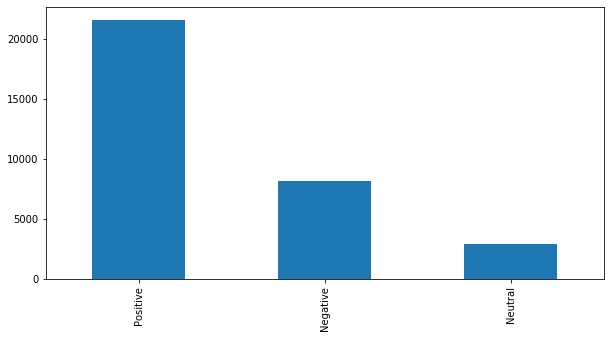

In [86]:
plt.figure().set_size_inches(10, 5)

CountSentiment = pd.value_counts(all_tweets_df['Sentiment_Label'].values, sort=True)
print (CountSentiment)

#CountStatus.plot.barh()
CountSentiment.plot.bar()
plt.show()

In [87]:
import pickle

with open('all_tweets_df.pickle', 'wb') as f:
    pickle.dump(all_tweets_df, f, pickle.HIGHEST_PROTOCOL)

In [4]:
import pickle

with open('all_tweets_df.pickle', 'rb') as f:
    all_tweets_df = pickle.load(f)

In [8]:
all_tweets_df['original_text']=new_data['Original_text']

In [18]:
with open('ldamodel.pickle', 'rb') as f:
    ldamodel = pickle.load(f)

In [8]:
#print(*ldamodel.print_topics(num_topics=15, num_words=20), sep='\n')

In [48]:
neg_art=all_tweets_df[(all_tweets_df['Sentiment_Label'] == 'Negative')]

In [100]:
neg_complete=[]
for x in neg_art['Text']:
    neg_complete.append(x)



In [91]:
neg_clean = [doc.split() for doc in neg_complete] 

In [92]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(neg_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in neg_clean]

In [93]:
import warnings
Lda = gensim.models.ldamodel.LdaModel
neg_art.shape

(8184, 3)

In [94]:
%time ldamodel_neg = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)
print(*ldamodel_neg.print_topics(num_topics=10, num_words=5), sep='\n')


/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/project/msca/ivy2/software/Anaconda3-2019.07/envs/nlp_class/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different res

CPU times: user 25min 5s, sys: 52min 58s, total: 1h 18min 3s
Wall time: 4min 44s
(0, '0.024*"police" + 0.023*"shot" + 0.021*"chicago" + 0.021*"said" + 0.021*"girl"')
(1, '0.025*"chicago" + 0.016*"police" + 0.014*"trump" + 0.010*"city" + 0.009*"said"')
(2, '0.013*"illinois" + 0.011*"state" + 0.007*"chicago" + 0.007*"arroyo" + 0.006*"house"')
(3, '0.018*"chicago" + 0.013*"goal" + 0.012*"game" + 0.012*"blackhawks" + 0.011*"season"')
(4, '0.013*"chicago" + 0.008*"like" + 0.008*"time" + 0.006*"would" + 0.006*"get"')
(5, '0.011*"said" + 0.011*"illinois" + 0.010*"fire" + 0.009*"child" + 0.007*"county"')
(6, '0.016*"share" + 0.013*"obama" + 0.012*"company" + 0.010*"stock" + 0.008*"illinois"')
(7, '0.012*"city" + 0.011*"said" + 0.009*"illinois" + 0.008*"pension" + 0.008*"year"')
(8, '0.029*"school" + 0.028*"teacher" + 0.020*"union" + 0.019*"strike" + 0.018*"chicago"')
(9, '0.021*"game" + 0.012*"illinois" + 0.011*"yard" + 0.010*"bear" + 0.008*"season"')


In [49]:
neg_art['Sentiment_Score'].describe()


count    8184.000000
mean       -0.033541
std         0.027783
min        -0.300000
25%        -0.045455
50%        -0.026490
75%        -0.013333
max        -0.000590
Name: Sentiment_Score, dtype: float64

In [56]:
#Run topic modelling on articles that have a sentiment score of less than -0.1
filtered_neg=neg_art[(neg_art['Sentiment_Score']<-0.1)]
neg_com_fil=[]
for x in filtered_neg['Text']:
    neg_com_fil.append(x)

neg_clean_fil = [doc.split() for doc in neg_com_fil]
dictionary = corpora.Dictionary(neg_clean_fil)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in neg_clean_fil]


In [3]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel_neg_fil = Lda(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50)



##### From above topics , it looks like crime and police shootings cause negative sentiment and result in negative population growth

### Positive Sentiment

In [9]:
pos_art=all_tweets_df[(all_tweets_df['Sentiment_Label'] == 'Positive')]

In [10]:

pos_complete=[]
for x in pos_art['Text']:
    pos_complete.append(x)



In [11]:
pos_clean = [doc.split() for doc in pos_complete]
dictionary = corpora.Dictionary(pos_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in pos_clean]
pos_art.shape


(21606, 4)

In [7]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel_pos = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)


In [121]:
with open('ldamodel_pos.pickle', 'wb') as f:
    pickle.dump(ldamodel_pos, f, pickle.HIGHEST_PROTOCOL)

In [122]:
print(*ldamodel_pos.print_topics(num_topics=10, num_words=20), sep='\n')

(0, '0.018*"chicago" + 0.006*"one" + 0.005*"like" + 0.005*"time" + 0.005*"said" + 0.005*"year" + 0.004*"city" + 0.004*"get" + 0.004*"people" + 0.004*"also" + 0.003*"know" + 0.003*"marathon" + 0.003*"make" + 0.003*"new" + 0.003*"day" + 0.003*"would" + 0.003*"even" + 0.003*"first" + 0.003*"police" + 0.003*"u"')
(1, '0.014*"owensillinois" + 0.011*"pm" + 0.010*"property" + 0.009*"cannabis" + 0.006*"home" + 0.006*"st" + 0.005*"marijuana" + 0.005*"park" + 0.005*"estate" + 0.005*"north" + 0.004*"building" + 0.004*"1" + 0.004*"real" + 0.004*"equity" + 0.004*"w" + 0.004*"sale" + 0.004*"am" + 0.004*"square" + 0.004*"glass" + 0.004*"new"')
(2, '0.028*"teacher" + 0.026*"school" + 0.020*"chicago" + 0.020*"said" + 0.019*"union" + 0.016*"strike" + 0.012*"city" + 0.011*"student" + 0.009*"class" + 0.009*"district" + 0.008*"day" + 0.007*"lightfoot" + 0.006*"public" + 0.006*"mayor" + 0.006*"contract" + 0.006*"support" + 0.005*"would" + 0.005*"size" + 0.004*"member" + 0.004*"year"')
(3, '0.114*"v" + 0.051

In [18]:
pos_art['Sentiment_Score'].describe()


count    21606.000000
mean         0.047509
std          0.036951
min          0.000224
25%          0.020619
50%          0.037037
75%          0.067416
max          0.407407
Name: Sentiment_Score, dtype: float64

In [38]:
#Run topic modelling on articles that have a sentiment score of more than 0.1

filtered_pos=pos_art[(pos_art['Sentiment_Score']>0.1)]

In [ ]:
pos_com_fil=[]
for x in filtered_pos['Text']:
    pos_com_fil.append(x)

pos_clean_fil = [doc.split() for doc in pos_com_fil]
dictionary = corpora.Dictionary(pos_clean_fil)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in pos_clean_fil]

Lda = gensim.models.ldamodel.LdaModel
ldamodel_pos_fil = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)


In [40]:
print(*ldamodel_pos_fil.print_topics(num_topics=5, num_words=12), sep='\n')

(0, '0.017*"chicago" + 0.005*"one" + 0.004*"great" + 0.004*"also" + 0.004*"hotel" + 0.003*"city" + 0.003*"time" + 0.003*"love" + 0.003*"get" + 0.003*"best" + 0.003*"like" + 0.003*"u"')
(1, '0.025*"chicago" + 0.015*"orleans" + 0.013*"new" + 0.012*"bear" + 0.012*"saint" + 0.010*"employee" + 0.010*"free" + 0.009*"detroit" + 0.007*"continue" + 0.006*"reading" + 0.006*"enjoy" + 0.006*"cincinnati"')
(2, '0.187*"v" + 0.101*"live" + 0.074*"illinois" + 0.023*"stream" + 0.017*"ohio" + 0.016*"purdue" + 0.014*"chicago" + 0.012*"michigan" + 0.011*"marathon" + 0.011*"golden" + 0.011*"miss" + 0.011*"northern"')
(3, '0.013*"job" + 0.009*"experience" + 0.009*"work" + 0.008*"team" + 0.008*"business" + 0.007*"chicago" + 0.007*"service" + 0.007*"skill" + 0.006*"customer" + 0.006*"client" + 0.006*"ability" + 0.005*"opportunity"')
(4, '0.021*"support" + 0.017*"technical" + 0.017*"email" + 0.017*"protected" + 0.016*"phone" + 0.016*"number" + 0.015*"1888499552o" + 0.015*"avast" + 0.007*"legal" + 0.005*"firm" 

#### From topics above, sports, hotels(tourism), marathon have a positive sentiment and may attract businesses

### NER on all articles - Ran NER tagger but didnt like the results

In [41]:
all_comm=[]
for x in new_data['Original_text']:
    y=re.sub(r"[^\w\s\d+]",'',str(x))
    all_comm.append(y)

words_all=', '.join(all_comm)
all_final=nltk.word_tokenize(words_all)
new_list_all=[]
for x in all_final:
    y=re.sub(r"[^a-zA-z]+",'',str(x))
    new_list_all.append(y)


new_list_all= [word for word in new_list_all if len(new_list_all) > 1]

# Remove numbers
new_list_all = [word for word in new_list_all if not word.isnumeric()]

new_list_all = [word for word in new_list_all if word.isalpha()]

# Remove stopwords
new_list_all_l = [word for word in new_list_all if word not in stopwords]


entities_all = []
labels_all = []
for chunk in nltk.ne_chunk(nltk.pos_tag(new_list_all_l), binary = False):
    if hasattr(chunk, 'label'):
        entities_all.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
        labels_all.append(chunk.label())
        
new_data_all=pd.DataFrame()
new_data_all['Entities']=entities_all
new_data_all['Labels']=labels_all
new_data_organization_all=new_data_all[new_data_all['Labels']=='ORGANIZATION']
new_data_location_all=new_data_all[new_data_all['Labels']=='LOCATION']
new_data_people_all=new_data_all[new_data_all['Labels']=='PERSON']

new_data_all.groupby("Labels").count()

with open('new_data_all.pickle', 'wb') as f:
    pickle.dump(new_data_all, f, pickle.HIGHEST_PROTOCOL)

In [45]:
new_data_gpe_all=new_data_all[new_data_all['Labels']=='GPE']

In [4]:
#new_data_people_all['Entities'].value_counts().head(50)

In [5]:
#new_data_organization_all['Entities'].value_counts().head(50)

In [6]:
#new_data_gpe_all['Entities'].value_counts().head(50)